# Sentiment Analysis for Mental Health: Detecting Depression and Anxiety Using NLP

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## EDA

In [2]:
# Load dataset 
df_original = pd.read_csv("Combined Data.csv")

/tmp/ipykernel_369327/2703740251.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_original['status'].value_counts().index,


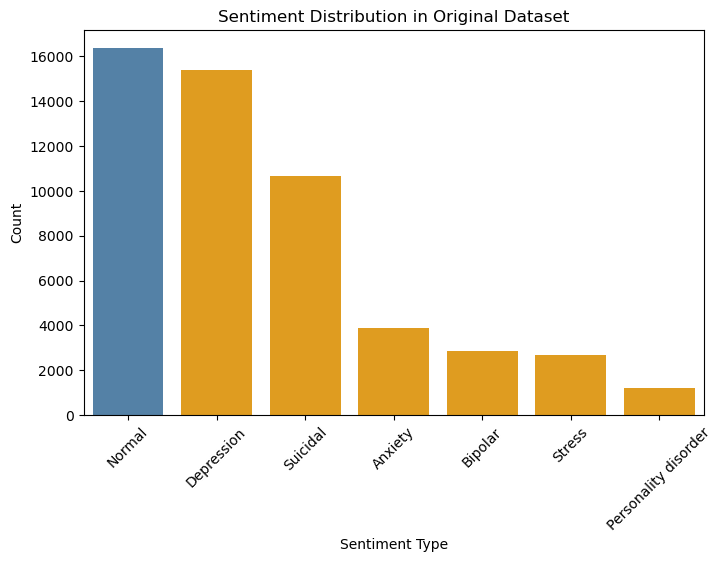

In [3]:
# Visualize sentiment categories
custom_colors = {
    'Normal': 'steelblue',  # Default cool color
    'Depression': 'orange',
    'Anxiety': 'orange',
    'Suicidal': 'orange',
    'Stress': 'orange',
    'Bipolar': 'orange',
    'Personality disorder': 'orange'
}

# Sort categories
sorted_categories = df_original['status'].value_counts().index

# Set colors based on the category
colors = [custom_colors[label] for label in sorted_categories]

plt.figure(figsize=(8,5))
sns.barplot(x=df_original['status'].value_counts().index, 
            y=df_original['status'].value_counts().values, 
            palette=colors)

# Labels and title
plt.xlabel("Sentiment Type")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Original Dataset")
plt.xticks(rotation=45)

plt.show()

count    53043.000000
mean       112.393285
std        163.436684
min          1.000000
25%         15.000000
50%         61.000000
75%        147.500000
max       6300.000000
Name: review_length, dtype: float64


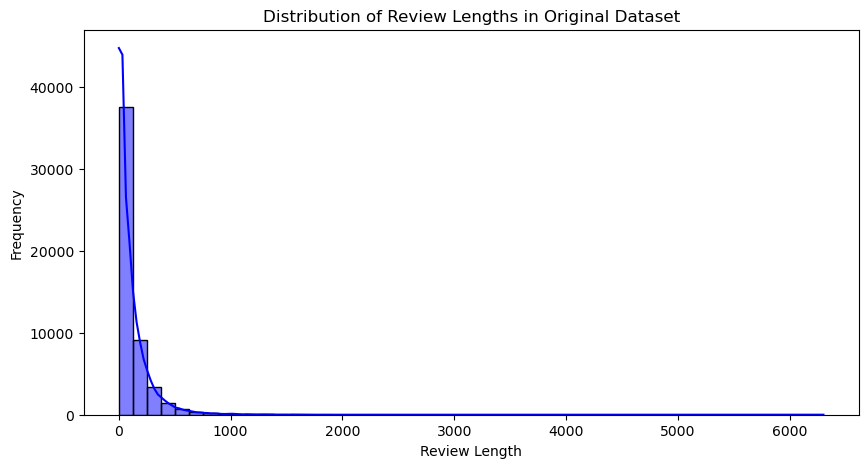

In [ ]:
# Summary statistics
df_original['review_length'] = df_original['statement'].astype(str).apply(lambda x: len(x.split()))

print(df_original['review_length'].describe())

# Histogram of review lengths
plt.figure(figsize=(10,5))
sns.histplot(df_original['review_length'], bins=50, kde=True, color="blue")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths in Original Dataset")
plt.show()

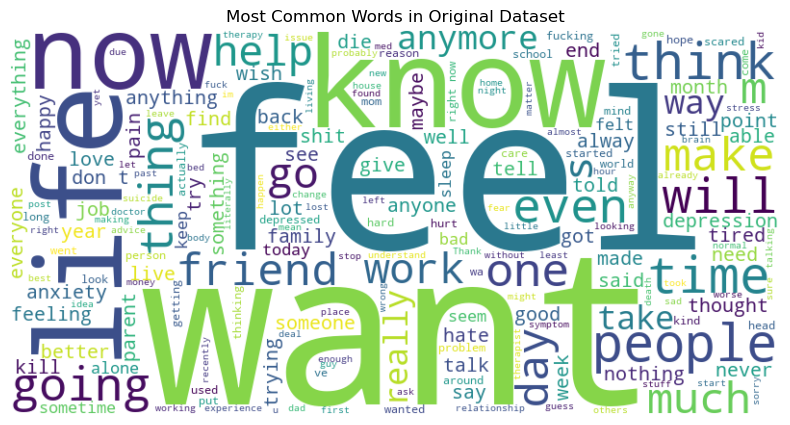

In [ ]:
# Word Cloud for Most Frequent Words
from wordcloud import WordCloud

text = " ".join(df_original['statement'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Original Dataset")
plt.show()

## Data Preprocessing

In [2]:
# Load dataset 
df = pd.read_csv("Combined Data.csv")

# Define a function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = word_tokenize(text)  # Tokenize words
    words = [w for w in words if w not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatization
    return ' '.join(words)

# Handle missing values in 'statement' column
df['statement'] = df['statement'].fillna('')


# Apply preprocessing
df['clean_text'] = df['statement'].apply(preprocess_text)

status_mapping = {
    'Normal': 0,
    'Depression': 1,
    'Anxiety': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Apply mapping to convert categorical labels into numeric values
df['status'] = df['status'].map(status_mapping)

# Verify if any unmapped values exist
if df['status'].isnull().sum() > 0:
    print("Warning: Some values in 'status' were not mapped correctly")

print("Data preprocessing completed!")


Data preprocessing completed!


In [3]:
# Drop NaN values
df = df.dropna(subset=['statement', 'status'])

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['status'], test_size=0.2, random_state=42)

## Comparing Count Vectorizer and TF-IDF Vectorizer Using Unigrams + Bigrams + Trigrams

## Model Training (Logistic Regression, Naïve Bayes, SVM)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Define different n-gram ranges
ngram_ranges = {
    "Unigram": (1,1),
    "Unigram+Bigram": (1,2),
    "Unigram+Bigram+Trigram": (1,3)
}

# Store results
results = []

for ngram_name, ngram_range in ngram_ranges.items():
    # Count Vectorizer
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_test_count = count_vectorizer.transform(X_test)

    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Naïve Bayes": MultinomialNB(),
        "SVM": SVC(kernel="linear")
    }

    # Train and evaluate models on Count Vectorizer
    for name, model in models.items():
        model.fit(X_train_count, y_train)
        y_pred = model.predict(X_test_count)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([ngram_name, "Count Vectorizer", name, acc, f1])

    # Train and evaluate models on TF-IDF Vectorizer
    for name, model in models.items():
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        results.append([ngram_name, "TF-IDF Vectorizer", name, acc, f1])

print("All models trained for different n-gram ranges")

### Table for comparison between Count Vectorizer and TF-IDF Vectorizer using different ngrams

In [ ]:
import pandas as pd
import ace_tools as tools

# Convert results into a DataFrame
df_results = pd.DataFrame(results, columns=["N-gram", "Vectorization", "Model", "Accuracy", "F1 Score"])

# Display the comparison table
tools.display_dataframe_to_user(name="N-gram Model Performance", dataframe=df_results)

## Comparing with Word2Vec

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec using CBOW and Skip-Gram
word2vec_model_cbow = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, sg=0)  # CBOW
word2vec_model_sg = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, sg=1)  # Skip-Gram

# Extract word vectors
word_vectors_cbow = word2vec_model_cbow.wv
word_vectors_sg = word2vec_model_sg.wv

# Function to convert text to vector representation
def vectorize_text(text, model, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model:
            vector += model[word]
            count += 1
    return vector / count if count > 0 else vector

# Convert training and test sets
X_train_w2v = np.array([vectorize_text(text, word_vectors_cbow) for text in X_train])
X_test_w2v = np.array([vectorize_text(text, word_vectors_cbow) for text in X_test])


Word2Vec transformation completed!


In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(kernel="linear")
}

# Train and evaluate models
results_w2v = []
for name, model in models.items():
    model.fit(X_train_w2v, y_train)
    y_pred = model.predict(X_test_w2v)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results_w2v.append(["Word2Vec (CBOW)", name, acc, f1])

print("Word2Vec model training completed!")

In [ ]:
# Comparing Word2Vev with TF-IDF and Count Vectorization
import pandas as pd
import ace_tools as tools

# Convert results into a DataFrame
df_results_w2v = pd.DataFrame(results_w2v, columns=["Vectorization", "Model", "Accuracy", "F1 Score"])

# Display the comparison table
tools.display_dataframe_to_user(name="Word2Vec vs TF-IDF vs Count Vectorization", dataframe=df_results_w2v)


## Model Training (LSTM)

In [11]:
from tensorflow.keras.models import load_model
model_lstm = load_model("lstm_model.keras")
# Evaluate LSTM Model
y_pred_lstm = model_lstm.predict(X_test_pad).argmax(axis=1)
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM F1-score:", f1_score(y_test, y_pred_lstm, average='macro'))

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


332/332 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step
LSTM Accuracy: 0.7428598359883118
LSTM F1-score: 0.6882969753454703
